# Guru strategies

In this analysis six guru strategies will be tested on companies from Warsaw Stock Exchange. These strategies were created basing on NYSE in various years.

The analyzed dataset was created with data from biznesradar.pl website and contains information from WSE companies' financial reports and some economic indices like USD/PLN exchange rate, GDP of Poland, unemployment rate etc., as well as all necessary indices for checking guru strategies. Each strategy would be tested only for observations, which provide all indices required by given strategy.

The purpose of this analysis is to check if given strategy properly classifies companies, which prices achieved more than 30% growth in the following year. This threshold is sufficient to provide earnings covering inflation rate, taxes and transaction fees, though it is possible to run this analysis using different value (just set variable threshold to another value).

The gathered data has following format:
- y/y growth of price from quarter T + 4 For example: we know that company X reported 20% y/y growth of share prices in Q2 2022
- all other indices are from quarter T
E.g. data for Q1 2020 for company X would include y/y growth of price from Q1 2021 and all other indices would contain data from Q1 2020.

In [157]:
# Packages loading
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

In [130]:
# Dataset loading

dataset = pd.read_csv('C:\\Users\\jsztu\\OneDrive\\Pulpit\\Python_projects\\Warsaw_Stock_Exchange\\data\\full_datasets\\dataset_30_11_2022.csv')

In [168]:
# Adding one hot encoded column 'high_growth'
# 1 - growth in following year exceeded threshold (30% in this analysis)
# 0 - otherwise
threshold = .3
dataset.high_growth = np.where(dataset.growth_of_price_yy > threshold, 1, 0)

The analyzed dataset's target is high_growth variable, an offshoot of growth_of_price_yy. There are 19 659 observations in the dataset, 5 011 of them reported growth greater than 30% in the following year. This treshold roughly corresponds with 75th percentile of growth_of_price_yy. On the other hand, the 50th percentile of this feature equals zero, which means that half of observations actually reported loss in the next year. There are also 1 827 observations with growth_of_price_yy greater than 100%. In the histogram below they are grouped in category '100%+'.

In [202]:
target_df = dataset.filter(['growth_of_price_yy', 'high_growth'])
print(dataset.high_growth.value_counts())
print(target_df.growth_of_price_yy.describe())

0    14648
1     5011
Name: high_growth, dtype: int64
count    1.965900e+04
mean     8.320913e+05
std      1.402083e+07
min     -9.963054e-01
25%     -2.632673e-01
50%      0.000000e+00
75%      3.102544e-01
max      1.600000e+09
Name: growth_of_price_yy, dtype: float64


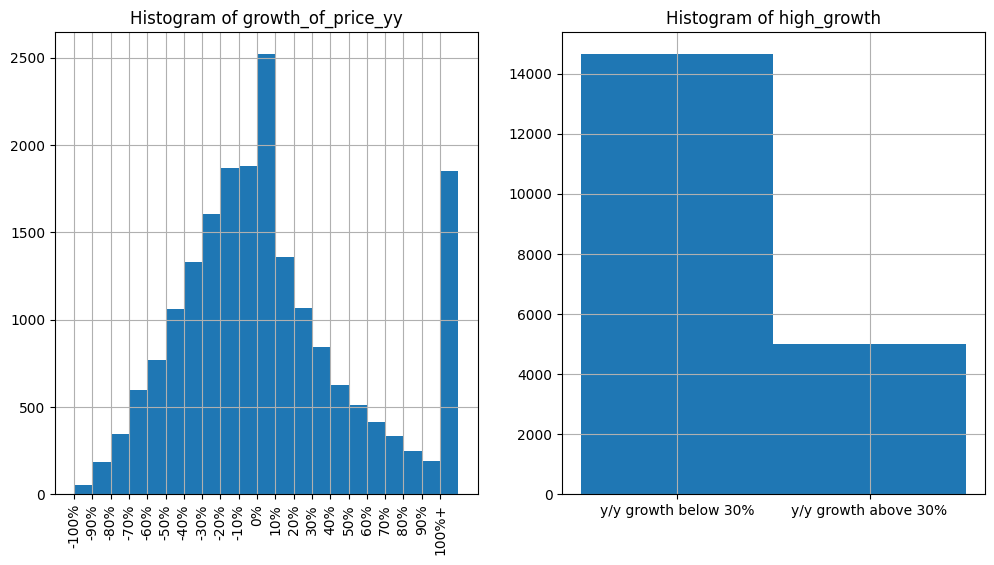

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

custom_bins = np.arange(-1, 1.2, .1)
xlabels = [str(val) + '%' for val in range(-100, 110, 10)]
xlabels[-1] += '+'

np.clip(
    target_df.growth_of_price_yy,
    custom_bins[0], custom_bins[-1]
).hist(bins=custom_bins, ax=ax[0])

target_df.high_growth.hist(ax=ax[1], bins=2)

ax[0].set_title('Histogram of growth_of_price_yy')
ax[0].set_xticks(.1*np.arange(-10, len([str(val) + '%' for val in range(-100, 10, 10)])))
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticks(
    [.25, .75],
    ['y/y growth below 30%', 'y/y growth above 30%'],
    minor=False
)
ax[1].set_title('Histogram of high_growth');

# Joel Greenblatt's magic formula

This strategy assumes, that we invest only in companies which:
- have capitalization greater than USD 50 million,
- are at the top of combined ranking of EV/EBIT and ROIC indices in given quarter:
    - EV/EBIT: Enterprise value to operating earnings ratio. The ratio informs about the degree of coverage of the operating earnings with the value of the enterprise. The lower the value of the ratio, the more attractive the investment can be.
    - ROIC: EBIT to sum of equity and net financial debt ratio. The higher the value of the ratio, the more attractive the investment can be.

For this strategy the following variables would be used:
- high_growth: dummy variable described above;
- capitalization_usd: number of shares multiplied by price of share in USD, has to be higher than 50 000 000;
- greenblatt_rank: combined rank of EV/EBIT and ROIC (i.e. mean position from these two rankings), companies in top 10 in each quarter would be considered;
- buy: signal from Greenblatt's strategy, 1 if company should be bought, 0 otherwise.

In [287]:
# Filter data
greenblatt_df = dataset.filter(['growth_of_price_yy', 'high_growth', 'capitalization_usd', 'greenblatt_rank'])

# Add column 'buy' for observations, which meet strategy conditions
greenblatt_df['buy'] = np.where(
    (greenblatt_df.capitalization_usd > 50000000) &
    (greenblatt_df.greenblatt_rank <= 10),
    1, 0
)
greenblatt_df = greenblatt_df.dropna()

The analyzed (sub)dataset contains 17 474 observations. 

In [291]:
greenblatt_df.describe()

,growth_of_price_yy,high_growth,capitalization_usd,greenblatt_rank,buy
count,17474.000000,17474.000000,1.747400e+04,17474.000000,17474.000000
mean,0.140298,0.243447,4.086278e+08,103.661955,0.018942
std,1.450963,0.429175,1.806057e+09,61.465710,0.136326
min,-0.996305,0.000000,6.306886e+03,1.000000,0.000000
25%,-0.282488,0.000000,1.371012e+07,53.000000,0.000000
50%,-0.025249,0.000000,3.943905e+07,99.000000,0.000000
75%,0.288491,0.000000,1.485975e+08,150.000000,0.000000
max,84.000000,1.000000,7.494402e+10,256.000000,1.000000


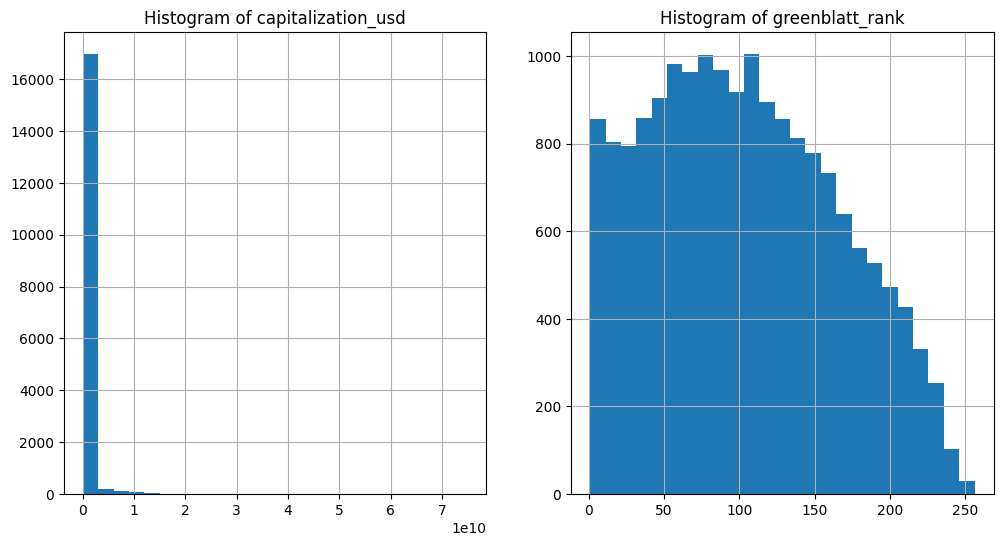

In [298]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

custom_bins = np.arange(0, 1.2, .1)
xlabels = [str(val) + '%' for val in range(-100, 110, 10)]
xlabels[-1] += '+'

greenblatt_df.capitalization_usd.hist(ax=ax[0], bins=25)
greenblatt_df.greenblatt_rank.hist(ax=ax[1], bins=25)

ax[0].set_title('Histogram of capitalization_usd')

ax[1].set_title('Histogram of greenblatt_rank');

The Greenblatt's formula considered 331 of them as worth buying. As we can observe in cross table of high_growth and buy, only 64 companies were properly classified as those, which reported growth was greater than 30% in following year.

In [162]:
# Cross table of high_growth and buy
print(pd.crosstab(greenblatt_df['high_growth'], greenblatt_df['buy']))


buy              0    1
high_growth            
0            12953  267
1             4190   64


In [163]:
print(classification_report(greenblatt_df['high_growth'], greenblatt_df['buy']))

              precision    recall  f1-score   support

           0       0.76      0.98      0.85     13220
           1       0.19      0.02      0.03      4254

    accuracy                           0.74     17474
   macro avg       0.47      0.50      0.44     17474
weighted avg       0.62      0.74      0.65     17474



In [159]:
roc_auc_score(greenblatt_df['high_growth'], greenblatt_df['buy'])

0.4974239960681306

While about 45% of observations had capitalization greater than USD 50 million, less than 

In [137]:
print((greenblatt_df['capitalization_usd'] > 50000000).value_counts(normalize=True))
print((greenblatt_df['greenblatt_rank'] <= 10).value_counts(normalize=True))

False    0.553222
True     0.446778
Name: capitalization_usd, dtype: float64
False    0.955648
True     0.044352
Name: greenblatt_rank, dtype: float64


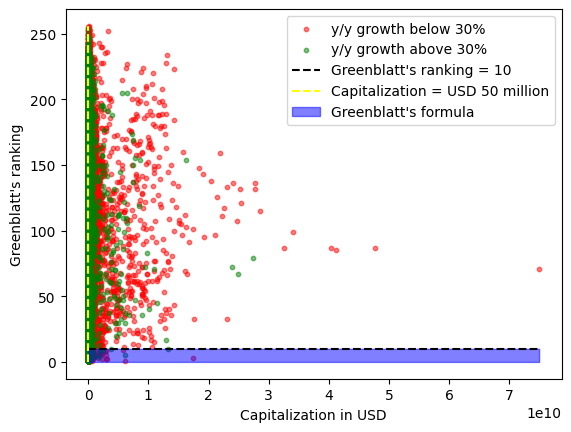

In [140]:
max_cap = max(greenblatt_df.capitalization_usd)
max_rank = max(greenblatt_df.greenblatt_rank)

fig, ax = plt.subplots()

scatter_x = np.array(greenblatt_df.capitalization_usd)
scatter_y = np.array(greenblatt_df.greenblatt_rank)
group = np.array(greenblatt_df.high_growth)
cdict = {0:'red', 1:'green'}
labels = ['y/y growth below 30%', 'y/y growth above 30%']

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(
        scatter_x[ix], scatter_y[ix], c = cdict[g],
        label = labels[g],
        s = 10, alpha=.5
    )

ax.hlines(
    y=10, xmin=0, xmax=max_cap, color='black', linestyle='dashed', 
    label='Greenblatt\'s ranking = 10'
)

ax.vlines(
    x=50000000, ymin=0, ymax=max_rank, color='yellow', linestyle='dashed',
    label='Capitalization = USD 50 million'
)

ax.fill_between(
    np.arange(50000000, max_cap, 1000000),
    10, color='blue', alpha=.5, label='Greenblatt\'s formula'
)

ax.set_ylabel('Greenblatt\'s ranking')
ax.set_xlabel('Capitalization in USD')
ax.legend();